In [1]:
import numpy as np
from numba import njit

In [2]:
# Model parameters
median = 1.75/1000
γ = 0.018
τ = median * γ
δ = 0.01
η = 0.032
ξ_m = 0.00256

μ_2 = 1.
ρ = 0.5
σ_2 = np.sqrt(0.21**2*2*ρ/μ_2) # Match moments, using 100 year's std

Equation:

$$
0 = \max_{e} \min_{h_2} - \delta \phi(r, z_2) + \delta \eta \log e - \tau z_2 e - \frac{\partial \phi}{\partial r}(r, z_2) e + \xi_m\frac{(h_2)^2}{2} + \left[\frac{\partial \phi}{\partial z_2}(r, z_2)\right]\left[-\rho (z_2 -\mu_2) + \sqrt{z_2} \sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial(z_2)^2}(r, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
$$

FOC of $h_2$ gives : 

$$
h_2^* = -\frac{\left[\frac{\partial \phi}{\partial z_2}(r, z_2)\right]\sqrt{z_2}\sigma_2}{\xi_m}
$$

FOC of $e$ gives :

$$
e^* = \frac{\delta \eta}{\tau z_2 + \frac{\partial \phi}{\partial r}(r, z_2)}
$$

Substituting terms we have:

$$
0 = - \delta \phi(r, z_2) + \delta \eta \log e^* - \tau z_2 e^* - \frac{\partial \phi}{\partial r}(r, z_2) e^* - \frac{1}{2\xi_m}\left[\frac{\partial \phi}{\partial z_2}(r, z_2)\right]^2z_2|\sigma_2|^2 + \left[\frac{\partial \phi}{\partial z_2}(r, z_2)\right]\left[-\rho (z_2 -\mu_2)\right] + \left[\frac{\partial^2 \phi}{\partial(z_2)^2}(r, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
$$

False transient method:

$$
\frac{{\color{red}{\phi_{i+1}(r, z_2)}}-{\color{blue}{\phi_{i}(r, z_2)}}}{\epsilon} = - \delta {\color{red}{\phi_{i+1}(r, z_2)}} + \delta \eta \log \color{blue}{e^*} - \tau z_2 \color{blue}{e^*} - \color{red}{\frac{\partial \phi_{i+1}}{\partial r}(r, z_2)} \color{blue}{e^*} - \frac{1}{2\xi_m}\left[\color{blue}{\frac{\partial \phi_i}{\partial z_2}(r, z_2)}\right]^2z_2|\sigma_2|^2 + \left[\color{red}{\frac{\partial \phi_{i+1}}{\partial z_2}(r, z_2)}\right]\left[-\rho (z_2 -\mu_2)\right] + \left[\color{red}{\frac{\partial^2 \phi_{i+1}}{\partial(z_2)^2}(r, z_2)}\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
$$

where

\begin{align*}
\color{red}{\frac{\partial \phi_{i+1}}{\partial r}(r, z_2)} & \approx \frac{\phi_{i+1}(r+\Delta r, z_2) - \phi_{i+1}(r, z_2)}{\Delta r} \mathbb{1}\{e^*<0\} + \frac{\phi_{i+1}(r, z_2) - \phi_{i+1}(r- \Delta r, z_2)}{\Delta r} \mathbb{1}\{e^*>0\}\\
\color{red}{\frac{\partial \phi_{i+1}}{\partial z_2}(r, z_2)} & \approx \frac{\phi_{i+1}(r, z_2+\Delta z) - \phi_{i+1}(r, z_2)}{\Delta z} \mathbb{1}\{z_2<\mu_2\} + \frac{\phi_{i+1}(r, z_2) - \phi_{i+1}(r, z_2- \Delta z)}{\Delta z} \mathbb{1}\{z_2>\mu_2\}\\
\color{red}{\frac{\partial^2 \phi_{i+1}}{\partial z_2^2}(r, z_2)} & \approx \frac{\phi_{i+1}(r, z_2 + \Delta z) - 2\phi_{i+1}(r, z_2) + \phi_{i+1}(r, z_2-\Delta z)}{(\Delta z)^2}
\end{align*}

1) Notice that on the boundary points, we use one-sided difference to estimate the first-order derivative;

2) $\color{blue}{\text{blue}}$ terms are calculated using the values from last iteration and $\color{red}{\text{red}}$ terms are to be calculated in this iteration.

In [3]:
@njit(parallel=True, cache=True)
def solver(ϕ_grid, r_grid, z_grid, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ):
    n_r = len(r_grid)
    n_z = len(z_grid)
    Δ_r = r_grid[1] - r_grid[0]
    Δ_z = z_grid[1] - z_grid[0]
    LHS = np.zeros((n_r*n_z, n_r*n_z))
    RHS = np.zeros(n_r*n_z)
    for j in range(n_z):
        for i in range(n_r):
            # Get index
            idx = j*n_r + i
            idx_rp1 = idx + 1
            idx_rm1 = idx - 1
            idx_zp1 = (j+1)*n_r + i
            idx_zp2 = (j+2)*n_r + i
            idx_zm1 = (j-1)*n_r + i
            idx_zm2 = (j-2)*n_r + i
            ϕ = ϕ_grid[idx]
            z = z_grid[j]
            LHS[idx, idx] = -δ - 1./ϵ
            # Compute values in blue
            if i == 0:
                dϕdr = (ϕ_grid[idx_rp1]-ϕ_grid[idx])/Δ_r
                e = δ*η/(τ*z+dϕdr)
                LHS[idx, idx] += e/Δ_r
                LHS[idx, idx_rp1] += -e/Δ_r
            elif i == n_r-1:
                dϕdr = (ϕ_grid[idx]-ϕ_grid[idx_rm1])/Δ_r
                e = δ*η/(τ*z+dϕdr)
                LHS[idx, idx] += -e/Δ_r
                LHS[idx, idx_rm1] += e/Δ_r
            else:
                dϕdr = (ϕ_grid[idx_rp1]-ϕ_grid[idx_rm1])/(2*Δ_r)
                e = δ*η/(τ*z+dϕdr)
                LHS[idx, idx] += e/Δ_r*(e<0) - e/Δ_r*(e>0)
                LHS[idx, idx_rp1] += -e/Δ_r*(e<0)
                LHS[idx, idx_rm1] += e/Δ_r*(e>0)
            temp_1 = - ρ*(z-μ_2)
            temp_2 = z*σ_2**2/2
            if j == 0:
                dϕdz = (ϕ_grid[idx_zp1]-ϕ_grid[idx])/Δ_z
                LHS[idx, idx] += -temp_1/Δ_z + temp_2/(Δ_z**2)  
                LHS[idx, idx_zp1] += temp_1/Δ_z - temp_2*2/(Δ_z**2)
                LHS[idx, idx_zp2] += temp_2/(Δ_z**2)
#                 LHS[idx, idx] += -temp_1/Δ_z
#                 LHS[idx, idx_zp1] += temp_1/Δ_z
            elif j == n_z-1:
                dϕdz = (ϕ_grid[idx]-ϕ_grid[idx_zm1])/Δ_z
                LHS[idx, idx] += temp_1/Δ_z + temp_2/(Δ_z**2)
                LHS[idx, idx_zm1] += -temp_1/Δ_z - temp_2*2/(Δ_z**2)
                LHS[idx, idx_zm2] += temp_2/(Δ_z**2)            
#                 LHS[idx, idx] += temp_1/Δ_z
#                 LHS[idx, idx_zm1] += -temp_1/Δ_z
            else:
                dϕdz = (ϕ_grid[idx_zp1]-ϕ_grid[idx_zm1])/(2*Δ_z)
                LHS[idx, idx] += temp_1/Δ_z*(-1.*(z<μ_2)+(z>μ_2)) - temp_2*2/(Δ_z**2)
                LHS[idx, idx_zp1] += temp_1/Δ_z*(z<μ_2) + temp_2/(Δ_z**2)
                LHS[idx, idx_zm1] += -temp_1/Δ_z*(z>μ_2) + temp_2/(Δ_z**2)
            RHS[idx] = -(1./ϵ*ϕ + δ*η*np.log(e) - τ*z*e - 1./(2*ξ_m)*dϕdz**2*z*σ_2**2)
    ϕ = np.linalg.solve(LHS, RHS)
    return ϕ


@njit
def false_transient(ϕ_grid, r_grid, z_grid, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ, max_iter=10_000, tol=1e-9):
    n_r = len(r_grid)
    n_z = len(z_grid)
    error = 1.
    count = 0
    while error > tol and count < max_iter:
        ϕ_grid_old = ϕ_grid.copy()
        ϕ_grid = solver(ϕ_grid, r_grid, z_grid, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ)
        error = np.max(np.abs(ϕ_grid_old-ϕ_grid))/ϵ
        count += 1
        print('Iteration:', count, ', error:', error)
    return ϕ_grid

In [4]:
ϵ = 0.5
r_max = 3000.
z_max = 1.0
n_r = 200
n_z = 20
r_grid = np.linspace(0, r_max, n_r)
z_grid = np.linspace(1e-5, z_max, n_z)
ϕ_grid = np.zeros(n_r*n_z) # initial guess

In [5]:
ϕ_grid = false_transient(ϕ_grid, r_grid, z_grid, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ, max_iter=10_000, tol=1e-7)

Iteration: 1 , error: 0.0015262708937060832
Iteration: 2 , error: 0.0009092206905049823
Iteration: 3 , error: 0.0007075615867611403
Iteration: 4 , error: 0.0006140811337687329
Iteration: 5 , error: 0.0005584461637345569
Iteration: 6 , error: 0.0005206794919680128
Iteration: 7 , error: 0.0004932928219833878
Iteration: 8 , error: 0.00047266677808217254
Iteration: 9 , error: 0.0004567233077026169
Iteration: 10 , error: 0.0004441426337359238
Iteration: 11 , error: 0.00043403485479849915
Iteration: 12 , error: 0.00042577686141203903
Iteration: 13 , error: 0.00041892015044497476
Iteration: 14 , error: 0.0004131360790141196
Iteration: 15 , error: 0.0004081797892329479
Iteration: 16 , error: 0.0004038669315184467
Iteration: 17 , error: 0.0004000571631341959
Iteration: 18 , error: 0.00039664317427438867
Iteration: 19 , error: 0.0003935417691103126
Iteration: 20 , error: 0.0003906886083805232
Iteration: 21 , error: 0.0003880334405492285
Iteration: 22 , error: 0.0003855368774182844
Iteration: 23 

Iteration: 180 , error: 0.00017427687571874156
Iteration: 181 , error: 0.00017340982658566734
Iteration: 182 , error: 0.00017254728507563877
Iteration: 183 , error: 0.0001716886479607091
Iteration: 184 , error: 0.00017083450789063398
Iteration: 185 , error: 0.0001699845527492333
Iteration: 186 , error: 0.000169138948863036
Iteration: 187 , error: 0.0001682973715990202
Iteration: 188 , error: 0.00016746007124268658
Iteration: 189 , error: 0.0001666270055861105
Iteration: 190 , error: 0.0001657980147538804
Iteration: 191 , error: 0.00016497310063141174
Iteration: 192 , error: 0.00016415242775810746
Iteration: 193 , error: 0.00016333564161168795
Iteration: 194 , error: 0.00016252314401923873
Iteration: 195 , error: 0.00016171445420840036
Iteration: 196 , error: 0.00016090990468524413
Iteration: 197 , error: 0.00016010935789596142
Iteration: 198 , error: 0.00015931289978697583
Iteration: 199 , error: 0.00015852021756240092
Iteration: 200 , error: 0.0001577317583771956
Iteration: 201 , erro

Iteration: 357 , error: 7.208541944588032e-05
Iteration: 358 , error: 7.172668724139686e-05
Iteration: 359 , error: 7.137000874768429e-05
Iteration: 360 , error: 7.101476422984032e-05
Iteration: 361 , error: 7.066159524410365e-05
Iteration: 362 , error: 7.030990740801435e-05
Iteration: 363 , error: 6.996010687380927e-05
Iteration: 364 , error: 6.961231225045827e-05
Iteration: 365 , error: 6.926571805039583e-05
Iteration: 366 , error: 6.892136027907003e-05
Iteration: 367 , error: 6.857822138121861e-05
Iteration: 368 , error: 6.823703619994459e-05
Iteration: 369 , error: 6.789771174299519e-05
Iteration: 370 , error: 6.755974971216216e-05
Iteration: 371 , error: 6.722363155127475e-05
Iteration: 372 , error: 6.688952583190633e-05
Iteration: 373 , error: 6.655640360503368e-05
Iteration: 374 , error: 6.622546280352082e-05
Iteration: 375 , error: 6.58957982525854e-05
Iteration: 376 , error: 6.556810232211108e-05
Iteration: 377 , error: 6.524174968740304e-05
Iteration: 378 , error: 6.491731717

Iteration: 535 , error: 2.966797074747951e-05
Iteration: 536 , error: 2.952043899118184e-05
Iteration: 537 , error: 2.937353543423782e-05
Iteration: 538 , error: 2.9227553712332655e-05
Iteration: 539 , error: 2.9081954799253795e-05
Iteration: 540 , error: 2.893726845705491e-05
Iteration: 541 , error: 2.879339659923874e-05
Iteration: 542 , error: 2.865006246044466e-05
Iteration: 543 , error: 2.8507514118425448e-05
Iteration: 544 , error: 2.8365685689799025e-05
Iteration: 545 , error: 2.8224673830401503e-05
Iteration: 546 , error: 2.808414218727351e-05
Iteration: 547 , error: 2.7944497077062036e-05
Iteration: 548 , error: 2.780549188759196e-05
Iteration: 549 , error: 2.7667057809724338e-05
Iteration: 550 , error: 2.7529635876141767e-05
Iteration: 551 , error: 2.739244851349132e-05
Iteration: 552 , error: 2.725616767496053e-05
Iteration: 553 , error: 2.7120672618244357e-05
Iteration: 554 , error: 2.6985805916313055e-05
Iteration: 555 , error: 2.6851496517585338e-05
Iteration: 556 , error:

Iteration: 711 , error: 1.2332779678020378e-05
Iteration: 712 , error: 1.2271422565129919e-05
Iteration: 713 , error: 1.221053321438792e-05
Iteration: 714 , error: 1.2149686439505425e-05
Iteration: 715 , error: 1.2089248109095618e-05
Iteration: 716 , error: 1.2029031557211911e-05
Iteration: 717 , error: 1.1969225062885558e-05
Iteration: 718 , error: 1.1909637441992471e-05
Iteration: 719 , error: 1.1850551277309274e-05
Iteration: 720 , error: 1.179170313739264e-05
Iteration: 721 , error: 1.1732764549854391e-05
Iteration: 722 , error: 1.1674681838394485e-05
Iteration: 723 , error: 1.1616312078466251e-05
Iteration: 724 , error: 1.1558518439855336e-05
Iteration: 725 , error: 1.1501120375179141e-05
Iteration: 726 , error: 1.1443794401058693e-05
Iteration: 727 , error: 1.1386860100506824e-05
Iteration: 728 , error: 1.1330209055249174e-05
Iteration: 729 , error: 1.1273999014654867e-05
Iteration: 730 , error: 1.1217841813210283e-05
Iteration: 731 , error: 1.1161941393403318e-05
Iteration: 732 

Iteration: 889 , error: 5.075770537765756e-06
Iteration: 890 , error: 5.050517947552402e-06
Iteration: 891 , error: 5.025399896760319e-06
Iteration: 892 , error: 5.000508497624012e-06
Iteration: 893 , error: 4.975538812693192e-06
Iteration: 894 , error: 4.950757701210895e-06
Iteration: 895 , error: 4.926130741170209e-06
Iteration: 896 , error: 4.901832907078241e-06
Iteration: 897 , error: 4.877232807107279e-06
Iteration: 898 , error: 4.853082008898779e-06
Iteration: 899 , error: 4.8288238481686285e-06
Iteration: 900 , error: 4.804949562800531e-06
Iteration: 901 , error: 4.780895373701632e-06
Iteration: 902 , error: 4.757299993954356e-06
Iteration: 903 , error: 4.733442610205252e-06
Iteration: 904 , error: 4.709961296103793e-06
Iteration: 905 , error: 4.686460840036544e-06
Iteration: 906 , error: 4.663145114561229e-06
Iteration: 907 , error: 4.640065007027738e-06
Iteration: 908 , error: 4.617167262285782e-06
Iteration: 909 , error: 4.593931438645615e-06
Iteration: 910 , error: 4.5710672

Iteration: 1065 , error: 2.1099643213173813e-06
Iteration: 1066 , error: 2.0994669863716453e-06
Iteration: 1067 , error: 2.089254709611299e-06
Iteration: 1068 , error: 2.078628733234722e-06
Iteration: 1069 , error: 2.0686138018505273e-06
Iteration: 1070 , error: 2.0580369824857447e-06
Iteration: 1071 , error: 2.047758517836895e-06
Iteration: 1072 , error: 2.0376196336741037e-06
Iteration: 1073 , error: 2.0276294915855253e-06
Iteration: 1074 , error: 2.0173467636525055e-06
Iteration: 1075 , error: 2.0073435901407644e-06
Iteration: 1076 , error: 1.9973235940301537e-06
Iteration: 1077 , error: 1.9873920199947603e-06
Iteration: 1078 , error: 1.9775210429312517e-06
Iteration: 1079 , error: 1.967728789506462e-06
Iteration: 1080 , error: 1.957871503005526e-06
Iteration: 1081 , error: 1.9482155904360088e-06
Iteration: 1082 , error: 1.938647035307217e-06
Iteration: 1083 , error: 1.928794682207191e-06
Iteration: 1084 , error: 1.9193018850061083e-06
Iteration: 1085 , error: 1.909650436393573e-06


Iteration: 1237 , error: 8.950421319653401e-07
Iteration: 1238 , error: 8.903206117627516e-07
Iteration: 1239 , error: 8.859570912317372e-07
Iteration: 1240 , error: 8.814935379547473e-07
Iteration: 1241 , error: 8.770982459632704e-07
Iteration: 1242 , error: 8.728341470004564e-07
Iteration: 1243 , error: 8.686894515663734e-07
Iteration: 1244 , error: 8.640722509029031e-07
Iteration: 1245 , error: 8.597733817949926e-07
Iteration: 1246 , error: 8.55515550082786e-07
Iteration: 1247 , error: 8.513296674284021e-07
Iteration: 1248 , error: 8.470046803238374e-07
Iteration: 1249 , error: 8.427926497106553e-07
Iteration: 1250 , error: 8.386825788297969e-07
Iteration: 1251 , error: 8.346065822756321e-07
Iteration: 1252 , error: 8.302742389443285e-07
Iteration: 1253 , error: 8.261435212320034e-07
Iteration: 1254 , error: 8.221968960664405e-07
Iteration: 1255 , error: 8.182771669418276e-07
Iteration: 1256 , error: 8.140628976471831e-07
Iteration: 1257 , error: 8.098252616828283e-07
Iteration: 125

Iteration: 1412 , error: 3.738106604811442e-07
Iteration: 1413 , error: 3.7195090589470237e-07
Iteration: 1414 , error: 3.7024957488807075e-07
Iteration: 1415 , error: 3.682591426523718e-07
Iteration: 1416 , error: 3.6647130492728497e-07
Iteration: 1417 , error: 3.6463805293263096e-07
Iteration: 1418 , error: 3.629054647624752e-07
Iteration: 1419 , error: 3.6099740707840056e-07
Iteration: 1420 , error: 3.59189132853599e-07
Iteration: 1421 , error: 3.5740212206425426e-07
Iteration: 1422 , error: 3.5566175639323294e-07
Iteration: 1423 , error: 3.5390048189198886e-07
Iteration: 1424 , error: 3.5233023400194075e-07
Iteration: 1425 , error: 3.5041690991943764e-07
Iteration: 1426 , error: 3.4859954653465586e-07
Iteration: 1427 , error: 3.468652203519884e-07
Iteration: 1428 , error: 3.4513952272552384e-07
Iteration: 1429 , error: 3.435376635663179e-07
Iteration: 1430 , error: 3.417138413619458e-07
Iteration: 1431 , error: 3.4001377260950427e-07
Iteration: 1432 , error: 3.3864792825522017e-07


Iteration: 1585 , error: 1.5773315872880111e-07
Iteration: 1586 , error: 1.5694841644375845e-07
Iteration: 1587 , error: 1.5616757821634852e-07
Iteration: 1588 , error: 1.5572453665457786e-07
Iteration: 1589 , error: 1.5461764796276256e-07
Iteration: 1590 , error: 1.5384829607500983e-07
Iteration: 1591 , error: 1.5308288153770278e-07
Iteration: 1592 , error: 1.5232722756775008e-07
Iteration: 1593 , error: 1.5156345765932056e-07
Iteration: 1594 , error: 1.508682108269932e-07
Iteration: 1595 , error: 1.5015819437858013e-07
Iteration: 1596 , error: 1.493125525997563e-07
Iteration: 1597 , error: 1.4885755711402382e-07
Iteration: 1598 , error: 1.4799415619382028e-07
Iteration: 1599 , error: 1.472866459767408e-07
Iteration: 1600 , error: 1.4636325962325003e-07
Iteration: 1601 , error: 1.4563508418663496e-07
Iteration: 1602 , error: 1.4491053146326038e-07
Iteration: 1603 , error: 1.4423566248311648e-07
Iteration: 1604 , error: 1.4347255222757482e-07
Iteration: 1605 , error: 1.4275843031319457

In [6]:
ϕ = ϕ_grid.reshape((n_r, n_z), order='F')

In [7]:
# Compute e_grid conditioned on z2
z_loc = 10
z = z_grid[z_loc]
Δ_r = r_grid[1] - r_grid[0]
dϕdr = np.zeros_like(r_grid) 
for i in range(n_r):
    if i == 0:
        dϕdr[i] = (ϕ[i+1, z_loc] - ϕ[i, z_loc])/Δ_r
    elif i == n_r-1:
        dϕdr[i] = (ϕ[i, z_loc] - ϕ[i-1, z_loc])/Δ_r
    else:
        dϕdr[i] = (ϕ[i+1, z_loc] - ϕ[i-1, z_loc])/(2*Δ_r)
e_grid = δ*η/(τ*z + dϕdr)

In [8]:
import matplotlib.pyplot as plt
# plt.plot(e_grid)

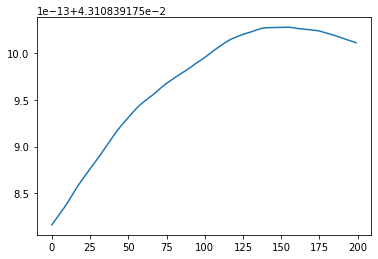

In [9]:
plt.plot(ϕ[:, 10])

In [10]:
ϕ[:, 10]

array([0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310839,
       0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310839,
       0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310839,
       0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310839,
       0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310839,
       0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310839,
       0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310839,
       0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310839,
       0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310839,
       0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310839,
       0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310839,
       0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310839,
       0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310839,
       0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310839,
       0.04310839, 0.04310839, 0.04310839, 0.04310839, 0.04310